## Obtaining shear stress for the flood experiments from summer 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import topography data
P2_topo = pd.read_csv('../../XS_topo/P2_topo.csv')
P3_topo = pd.read_csv('../../XS_topo/P3_topo.csv')
P4_topo = pd.read_csv('../../XS_topo/P4_topo.csv')
P6_topo = pd.read_csv('../../XS_topo/P6_topo.csv')
# using ../ since we are going back a folder to get to the data

# import depth data and make date the index
water_depth = pd.read_csv('depths_experiments.csv', index_col='Date_Time', parse_dates=True)

Function definition

In [2]:
def get_hydraulic_radius(X, Y, WSE):
    wet_areas = []
    wet_perimeters = []
    poly_x = []
    poly_y = []

    # Loop through the points of the cross-section to find wet polygon
    for i in range(len(X) - 1):
        y1, y2 = Y[i], Y[i+1]
        x1, x2 = X[i], X[i+1]

        # First, checking if we enter the water
        if (y1 >= WSE and y2 < WSE):
            # Linear interpolation to find the intersection point
            x_int1 = x1 + (WSE - y1) * (x2 - x1) / (y2 - y1)
            poly_x.append(x_int1)
            poly_y.append(WSE)
        
        # If not, we check if the first point is below the WSE
        if (y1 < WSE):
            poly_x.append(x1)
            poly_y.append(y1)
        
        # Then, we check if we go out of the water. If we did, we calculate the area and store it
        if (y1 < WSE and y2 >= WSE):
            # Linear interpolation to find the intersection point
            x_int2 = x1 + (WSE - y1) * (x2 - x1) / (y2 - y1)
            poly_x.append(x_int2)
            poly_y.append(WSE)

            # Closing the polygon
            if len(poly_x) > 0:
                poly_x.append(poly_x[0])
                poly_y.append(poly_y[0])
            
            # Calculating the area
            tempCalc1 = 0.5 * np.abs(np.dot(poly_x, np.roll(poly_y, 1)) - np.dot(poly_y, np.roll(poly_x, 1)))
            wet_areas.append(tempCalc1)

            # Calculating the wet perimeter
            distances = np.sqrt(np.diff(poly_x)**2 + np.diff(poly_y)**2)
            wet_perimeters.append(np.sum(distances[:-1]))

            # Resetting the polygon
            poly_x = []
            poly_y = []
    
    # return hydraulic radius, wet area, wet perimeter
    tempCalc1 = np.sum(wet_areas)
    wet_area = tempCalc1
    tempCalc2 = np.sum(wet_perimeters)
    wet_perimeter = tempCalc2
    # check if tempCalc2 is zero to avoid division by zero
    if tempCalc2 == 0:
        hydraulic_radius = float('nan')  
    else:
        hydraulic_radius = tempCalc1 / tempCalc2
    
    return hydraulic_radius, wet_area, wet_perimeter

def calculate_hydraulic_radius(topography_df, depth_timeseries, depth_location):
    X = topography_df['distance'].values
    Z = topography_df['elevation'].values
    depth = depth_timeseries['depth'].values
    times = depth_timeseries.index 

    #find the riverbed elevation at the depth measurement location
    riverbed_elevation_at_depth_location = np.interp(depth_location, X, Z)

    hyd_rad = [] 
    wet_area = []
    wet_perimeter = []

    # loop over each time step and calculate hydraulic radius
    for d in depth:
        wse = riverbed_elevation_at_depth_location + d  # wse at this time step
        hydraulic_radius_calc, wet_area_calc, wet_perimeter_calc = get_hydraulic_radius(X, Z, wse)  # calculate hydraulic radius
        hyd_rad.append(hydraulic_radius_calc)
        wet_area.append(wet_area_calc)
        wet_perimeter.append(wet_perimeter_calc)

    # create a DataFrame with time and hydraulic radius for each time step
    R_timeseries = pd.DataFrame({
        'time': times,
        'hydraulic_radius': hyd_rad,
        'wet_area': wet_area,
        'wet_perimeter': wet_perimeter
    }).set_index('time')
    return R_timeseries, 

Prepping data

In [3]:
# 2023 piezometers
P2_depth = pd.DataFrame(water_depth['P2'])
P2_depth.columns = ['depth']
P3_depth = pd.DataFrame(water_depth['P3'])
P3_depth.columns = ['depth']

Calculate hydraulic radius and wetted perimeter

In [4]:
# hydraulic radius
P2 = calculate_hydraulic_radius(P2_topo, P2_depth, 0.7)
P3 = calculate_hydraulic_radius(P3_topo, P3_depth, 0.6)

hydraulic_radius = pd.DataFrame({
    'P2': P2[0]['hydraulic_radius'],
    'P3': P3[0]['hydraulic_radius'],
})
    
wet_area = pd.DataFrame({
    'P2': P2[0]['wet_area'],
    'P3': P3[0]['wet_area'],
})
wet_area

,P2,P3
time,,
2023-09-18 12:00:00,0.119906,0.087644
2023-09-18 12:01:00,0.123469,0.085662
2023-09-18 12:02:00,0.120348,0.085802
2023-09-18 12:03:00,0.123920,0.084544
2023-09-18 12:04:00,0.124145,0.084683
...,...,...
2023-09-24 06:45:00,0.130107,0.066214
2023-09-24 06:46:00,0.123245,0.064576
2023-09-24 06:47:00,0.124365,0.066214


Obtain discharge from P3

In [5]:
# ...existing code...
# vectorized implementation (works on a Series)
water_depth['Q'] = np.where(
    water_depth['P3'] > 0.19682911,
    0.5757 * (water_depth['P3'] * 100) - 10.7,
    0.000000006 * (water_depth['P3'] * 100) ** 6.1991
)

# discharge dataframes - discharge is in cfs, need to convert to m3/s
discharge = water_depth[['Q']] * 0.028316847
discharge

,Q
Date_Time,
2023-09-18 12:00:00,0.005314
2023-09-18 12:01:00,0.004990
2023-09-18 12:02:00,0.005013
2023-09-18 12:03:00,0.004812
2023-09-18 12:04:00,0.004834
...,...
2023-09-24 06:45:00,0.002362
2023-09-24 06:46:00,0.002188
2023-09-24 06:47:00,0.002362


Calculate velocity in each cross section (U=Q/A)

In [6]:
velocity = pd.merge(wet_area, discharge, left_index=True, right_index=True, how='inner')
print(velocity)
velocity['P2_U'] = velocity['Q'] / velocity['P2'] 
velocity['P3_U'] = velocity['Q'] / velocity['P3'] 
print(velocity)

                           P2        P3         Q
time                                             
2023-09-18 12:00:00  0.119906  0.087644  0.005314
2023-09-18 12:01:00  0.123469  0.085662  0.004990
2023-09-18 12:02:00  0.120348  0.085802  0.005013
2023-09-18 12:03:00  0.123920  0.084544  0.004812
2023-09-18 12:04:00  0.124145  0.084683  0.004834
...                       ...       ...       ...
2023-09-24 06:45:00  0.130107  0.066214  0.002362
2023-09-24 06:46:00  0.123245  0.064576  0.002188
2023-09-24 06:47:00  0.124365  0.066214  0.002362
2023-09-24 06:48:00  0.126645  0.066214  0.002362
2023-09-24 06:49:00  0.124365  0.066214  0.002362

[8271 rows x 3 columns]
                           P2        P3         Q      P2_U      P3_U
time                                                                 
2023-09-18 12:00:00  0.119906  0.087644  0.005314  0.044320  0.060635
2023-09-18 12:01:00  0.123469  0.085662  0.004990  0.040418  0.058257
2023-09-18 12:02:00  0.120348  0.085802  0.00

Reach average velocity

In [7]:
average_velocity = velocity[['P3_U', 'P2_U']].mean(axis=1) # orignal code in 2023 is also only using these two!! 
average_hydraulic_radius = hydraulic_radius[['P3', 'P2']].mean(axis=1)

### Total Shear Stress
$\tau = g \rho s R$

In [8]:
# assigning the other variables
rho = 1000  # density of water in kg/m^3
g = 9.81  # acceleration due to gravity in m/s^2
s = 0.0945 # reach slope in m/m
# calculate shear stress for each time step
total_shear_stress = rho * g * s * average_hydraulic_radius

### Mobile Shear Stress 

$\tau_m = \frac{\rho  C_m  U^2}{2}$

Assuming $C_m$ as 0.44 as per [Yager 2012](https://doi.org/10.1029/2011WR010829)

In [9]:
rho = 1000  # density of water in kg/m^3
mobile_shear_stress = (rho * 0.44 * average_velocity**2) / 2
mobile_shear_stress.columns = ['shear_stress']

### Plots

In [10]:
# separate by days where piezo was actually in the water
# use .loc to slice and concat along columns
start = '2023-09-20 12:55:00'
end   = '2023-09-20 15:30:00'

day1 = pd.concat([
    mobile_shear_stress.loc[start:end].rename('shear_stress'),
    discharge.loc[start:end],
    average_velocity.loc[start:end].rename('U'),
    average_hydraulic_radius.loc[start:end].rename('R'),
    P3_depth.loc[start:end]['depth'],
    wet_area.loc[start:end]['P3'],
    wet_area.loc[start:end]['P2'],
], axis=1, join='inner')

start = '2023-09-21 10:35:00'
end   = '2023-09-21 11:34:00'

day2 = pd.concat([
    mobile_shear_stress.loc[start:end].rename('shear_stress'),
    discharge.loc[start:end],
    average_velocity.loc[start:end].rename('U'),
    average_hydraulic_radius.loc[start:end].rename('R'),
    P3_depth.loc[start:end]['depth'],
    wet_area.loc[start:end]['P3'],
    wet_area.loc[start:end]['P2'],
], axis=1, join='inner')

sns.set_style('darkgrid')

#### Day 1

Depth

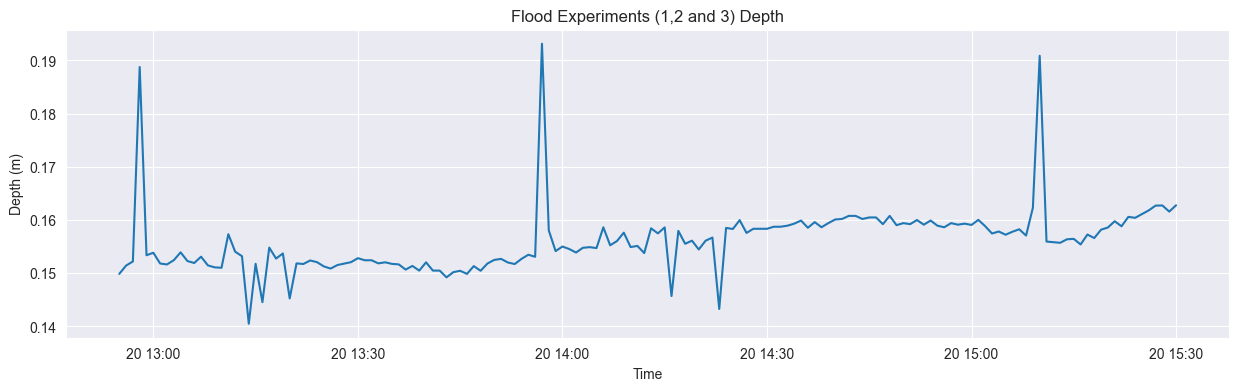

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(day1['depth'])
plt.title('Flood Experiments (1,2 and 3) Depth')
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.show()

Wet Area

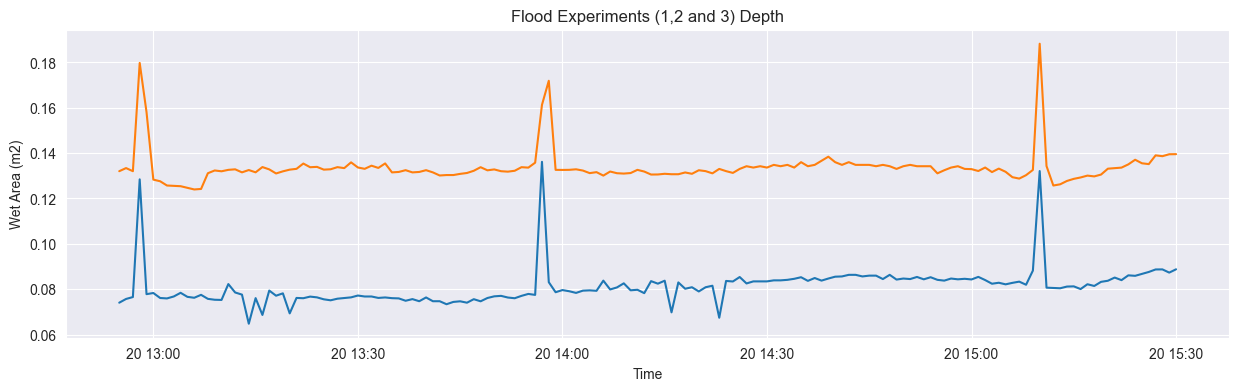

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(day1['P3'])
plt.plot(day1['P2'])
plt.title('Flood Experiments (1,2 and 3) Depth')
plt.xlabel('Time')
plt.ylabel('Wet Area (m2)')
plt.show()

Hydraulic Radius

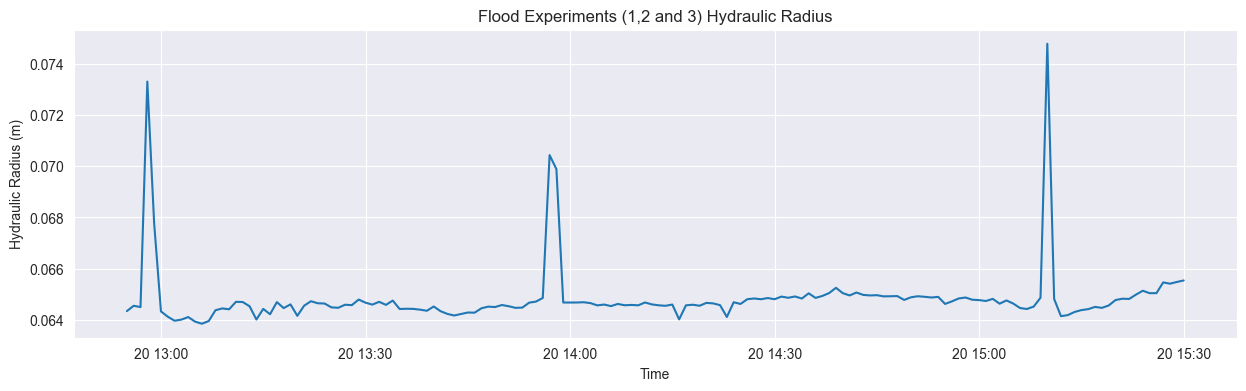

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(day1['R'])
plt.title('Flood Experiments (1,2 and 3) Hydraulic Radius')
plt.xlabel('Time')
plt.ylabel('Hydraulic Radius (m)')
plt.show()

Velocity

C:\Users\huck4481\AppData\Local\Temp\ipykernel_420\4133808379.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


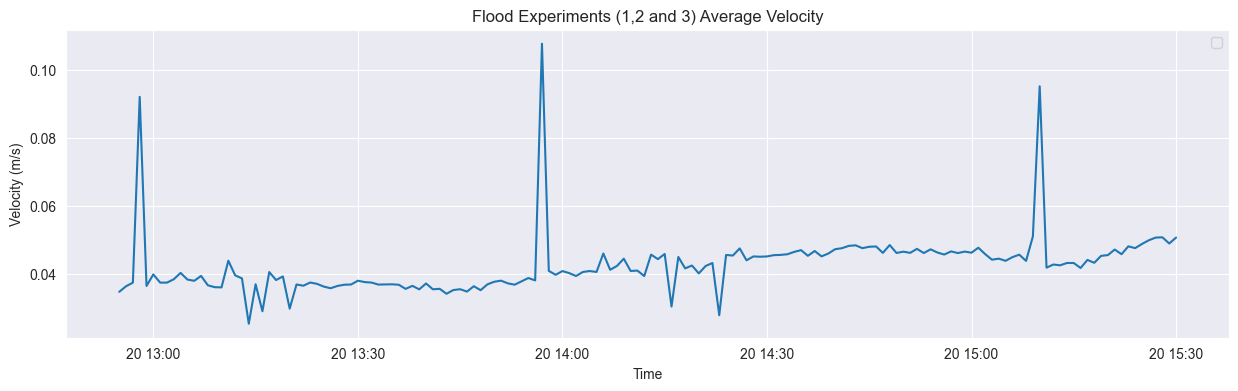

In [14]:
plt.figure(figsize=(15, 4))

plt.plot(day1['U'])
plt.title('Flood Experiments (1,2 and 3) Average Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.legend()
#plt.ylim(0, 200)
plt.show()

Shear Stress

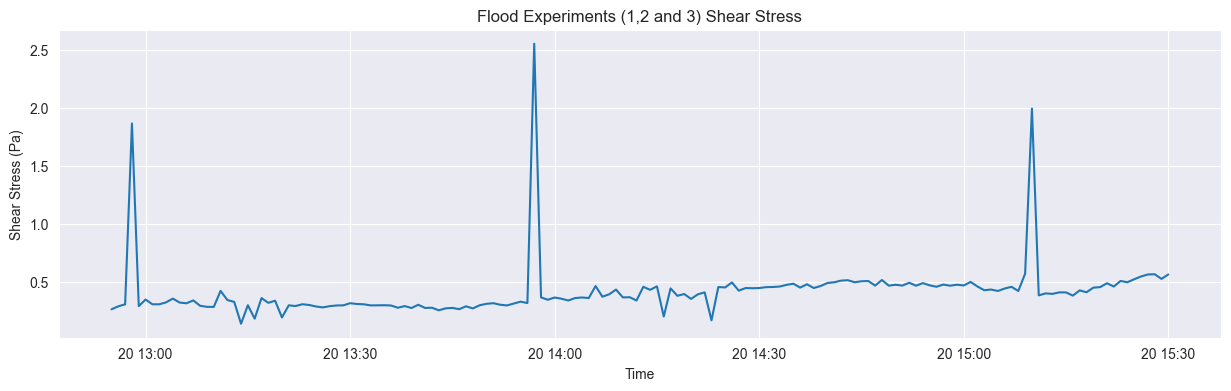

In [15]:
plt.figure(figsize=(15, 4))
plt.plot(day1['shear_stress'])
plt.title('Flood Experiments (1,2 and 3) Shear Stress')
plt.xlabel('Time')
plt.ylabel('Shear Stress (Pa)')
plt.show()

#### Day 2

Depth

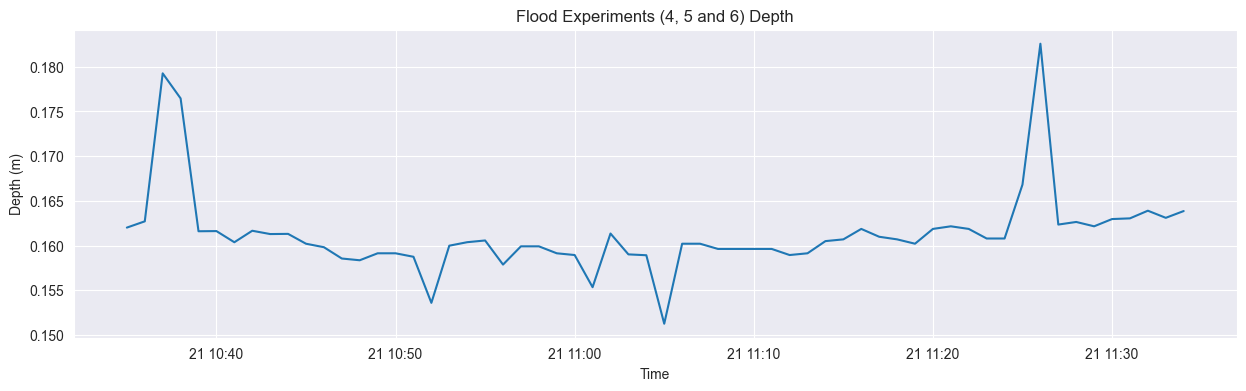

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(day2['depth'])
plt.title('Flood Experiments (4, 5 and 6) Depth')
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.show()

Wet Area

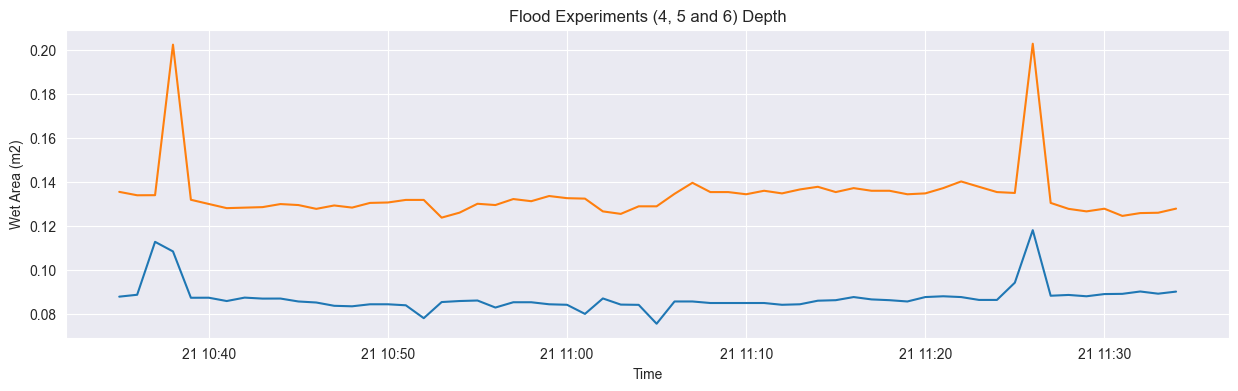

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(day2['P3'])
plt.plot(day2['P2'])
plt.title('Flood Experiments (4, 5 and 6) Depth')
plt.xlabel('Time')
plt.ylabel('Wet Area (m2)')
plt.show()

Hydraulic Radius

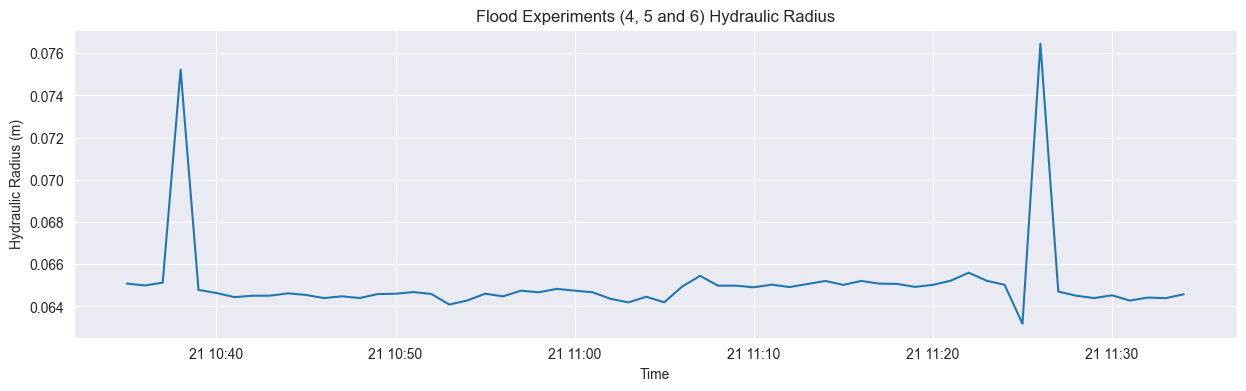

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(day2['R'])
plt.title('Flood Experiments (4, 5 and 6) Hydraulic Radius')
plt.xlabel('Time')
plt.ylabel('Hydraulic Radius (m)')
plt.show()

Velocity

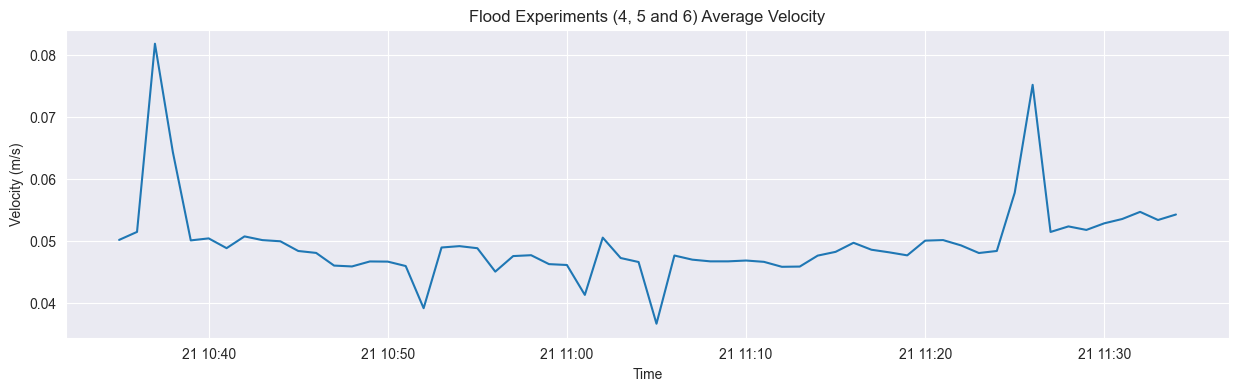

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(day2['U'])
plt.title('Flood Experiments (4, 5 and 6) Average Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.show()

Shear Stress

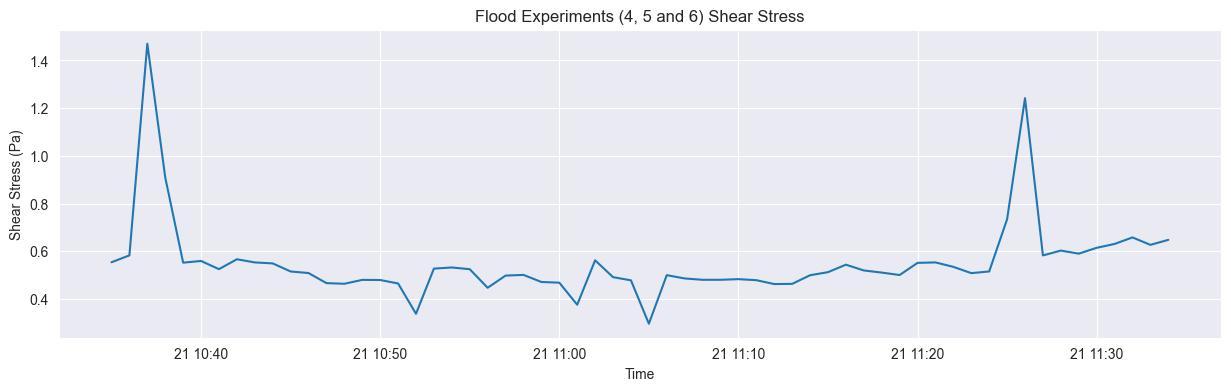

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(day2['shear_stress'])
plt.title('Flood Experiments (4, 5 and 6) Shear Stress')
plt.xlabel('Time')
plt.ylabel('Shear Stress (Pa)')
plt.show()

#### Export to CSV

In [21]:
# change column names as needed 
day1.columns = ['shear_stress', 'discharge', 'avg_U', 'R', 'depth', 'wet_area_P3', 'wet_area_P2']
day2.columns = ['shear_stress', 'discharge', 'avg_U', 'R', 'depth', 'wet_area_P3', 'wet_area_P2']
# concatenate day1 and day2
combined = pd.concat([day1, day2])
# export
day1.to_csv('flood_experiment_1_2_3_shear_stress.csv')
day2.to_csv('flood_experiment_4_5_6_shear_stress.csv')
combined.to_csv('calibration_experiments_shear_stress.csv')